In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import h5py
import glob
from scipy import io 
import matplotlib.pyplot as plt

In [3]:
from scipy.ndimage import convolve1d, gaussian_filter1d
from scipy.interpolate import interp1d

In [214]:
import sys
sys.path.append('..')
from loaders import split_shenoy, load_shenoy

In [5]:
from pyuoi.linear_model.var import VAR
from decoders import standardize
from sklearn.linear_model import LinearRegression
from neurosim.models.var import form_companion

In [6]:
from dca.methods_comparison import JPCA

### Inspecting structure of the raw data

In [12]:
data_path = '/mnt/Secondary/data/shenoy'

In [13]:
data_files = glob.glob('%s/*.mat' % data_path)

In [14]:
data_files

['/mnt/Secondary/data/shenoy/N,2009-09-18,1-2,good-ss.mat',
 '/mnt/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat']

In [15]:
f = io.loadmat(data_files[0], squeeze_me=True, struct_as_record=False)

In [78]:
f['Ns'][0].cond[0].mazeID

{'_fieldnames': ['mazeID',
  'trialVersion',
  'protoTrial',
  'TargLocked',
  'GoLocked',
  'MoveLocked',
  'interpPSTH'],
 'mazeID': 1,
 'trialVersion': 0,
 'protoTrial': <scipy.io.matlab.mio5_params.mat_struct at 0x7ff519376cd0>,
 'TargLocked': <scipy.io.matlab.mio5_params.mat_struct at 0x7ff51937c610>,
 'GoLocked': <scipy.io.matlab.mio5_params.mat_struct at 0x7ff51937c790>,
 'MoveLocked': <scipy.io.matlab.mio5_params.mat_struct at 0x7ff51937c890>,
 'interpPSTH': array([8.17447957e-01, 8.30271452e-01, 8.46822254e-01, 8.62217836e-01,
        8.69537135e-01, 8.63205820e-01, 8.41907278e-01, 8.08647897e-01,
        7.68043407e-01, 7.23322665e-01, 6.75441120e-01, 6.24281869e-01,
        5.70044573e-01, 5.13568425e-01, 4.56170320e-01, 3.99967134e-01,
        3.48334344e-01, 3.05307891e-01, 2.73712215e-01, 2.53408282e-01,
        2.41373433e-01, 2.33945068e-01, 2.29673399e-01, 2.30373264e-01,
        2.39043298e-01, 2.55900824e-01, 2.75856171e-01, 2.90082207e-01,
        2.90959358e-01, 2.

In [130]:
f['Ns'][0].cond[0].MoveLocked.__dict__

{'_fieldnames': ['meanFR', 'semFR', 'numTrials'],
 'meanFR': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.41804840e-03, 8.57333758e-03,
        4.04197782e-02, 1.51271916e-01, 4.60756538e-01, 1.17099658e+00,
        2.54878962e+00, 4.84103827e+00, 8.15441920e+00, 1.23555321e+01,
        1.70994753e+01, 2.19583532e+01, 2.64512425e+01, 3.00557637e+01,
        3.24583929e+01, 3.37904794e+01, 3.44333703e+01, 3.45501704e+01,
        3.39352572e+01, 3.23840428e+01, 3.01494149e+01, 2.79514969e+01,
        2.63556262e+01, 2.52204793e+01, 2.39642168e+01, 2.22654145e+01,
        2.02461638e+01, 1.80773721e+01, 1.57430483e+01, 1.32272139e+01,
        1.06869165e+01, 8.41498766e+00, 6.63008439e+00, 5.33630020e+00,
    

In [131]:
# What are the unique combinations of trialVersion and mazeID, and compare the corresponding trial
Ns_trial_dict = {}
for i in range(len(f['Ns'][0].cond)):
    ntrials = []

    trialVersion = f['Ns'][0].cond[i].trialVersion
    mazeID = f['Ns'][0].cond[i].mazeID

    for j in range(len(f['Ns'])):
        # Ensure order of trial versions and maze IDs are consistent across units
        assert(f['Ns'][j].cond[i].trialVersion == trialVersion)
        assert(f['Ns'][j].cond[i].mazeID == mazeID)

        ntrials.append(f['Ns'][j].cond[i].MoveLocked.numTrials)
        ntrials.append(f['Ns'][j].cond[i].TargLocked.numTrials)
        ntrials.append(f['Ns'][j].cond[i].GoLocked.numTrials)

    Ns_trial_dict[(trialVersion, mazeID)] = max(ntrials)


In [132]:
Ns_trial_dict

{(0, 1): 18,
 (1, 1): 15,
 (2, 1): 19,
 (0, 2): 21,
 (1, 2): 21,
 (2, 2): 21,
 (0, 3): 22,
 (1, 3): 24,
 (2, 3): 19,
 (0, 5): 17,
 (1, 5): 20,
 (2, 5): 23,
 (0, 6): 21,
 (1, 6): 15,
 (2, 6): 15,
 (0, 7): 20,
 (1, 7): 18,
 (2, 7): 21,
 (0, 16): 19,
 (1, 16): 22,
 (2, 16): 19,
 (0, 17): 22,
 (1, 17): 19,
 (2, 17): 22,
 (0, 18): 21,
 (1, 18): 23,
 (2, 18): 14,
 (0, 65): 20,
 (1, 65): 19,
 (2, 65): 22,
 (0, 66): 24,
 (1, 66): 20,
 (2, 66): 19,
 (0, 67): 20,
 (1, 67): 20,
 (2, 67): 19,
 (0, 71): 26,
 (1, 71): 19,
 (2, 71): 22,
 (0, 72): 21,
 (1, 72): 21,
 (2, 72): 20,
 (0, 73): 21,
 (1, 73): 21,
 (2, 73): 20,
 (0, 75): 23,
 (1, 75): 21,
 (2, 75): 19,
 (0, 76): 26,
 (1, 76): 18,
 (2, 76): 18,
 (0, 77): 21,
 (1, 77): 19,
 (2, 77): 21,
 (0, 79): 22,
 (1, 79): 21,
 (2, 79): 21,
 (0, 80): 20,
 (1, 80): 22,
 (2, 80): 18,
 (0, 81): 22,
 (1, 81): 20,
 (2, 81): 19,
 (0, 83): 21,
 (1, 83): 18,
 (2, 83): 20,
 (0, 84): 20,
 (1, 84): 25,
 (2, 84): 16,
 (0, 85): 24,
 (1, 85): 24,
 (2, 85): 19,
 (0, 87): 

In [79]:
f2 = io.loadmat(data_files[1], squeeze_me=True, struct_as_record=False)

In [105]:
f2['R'][0].unit[0].__dict__

{'_fieldnames': ['spikeTimes'], 'spikeTimes': 2612.366666666666}

In [29]:
# Might have to do something with unitlookup, arraylookup?

In [144]:
trialVersion = []
for i in range(f2['R'].size):
    trialVersion.append(f2['R'][i].trialVersion)
trial_id
    mazeIDs.append(f2['R'][i].mazeID)

In [146]:
mazeIDs

[0,
 0,
 77,
 71,
 100,
 76,
 87,
 65,
 91,
 16,
 92,
 100,
 2,
 99,
 98,
 89,
 83,
 77,
 67,
 76,
 101,
 4,
 89,
 85,
 65,
 17,
 93,
 80,
 101,
 17,
 85,
 4,
 74,
 83,
 87,
 98,
 88,
 6,
 96,
 88,
 88,
 17,
 76,
 16,
 3,
 84,
 6,
 1,
 83,
 2,
 84,
 17,
 1,
 18,
 73,
 66,
 17,
 100,
 71,
 80,
 6,
 17,
 88,
 6,
 18,
 66,
 97,
 18,
 3,
 76,
 18,
 72,
 65,
 81,
 95,
 96,
 1,
 18,
 99,
 93,
 65,
 92,
 66,
 73,
 16,
 5,
 81,
 81,
 83,
 75,
 2,
 79,
 92,
 96,
 67,
 5,
 73,
 72,
 98,
 97,
 7,
 99,
 93,
 7,
 91,
 81,
 92,
 71,
 84,
 77,
 72,
 65,
 72,
 97,
 3,
 79,
 71,
 81,
 75,
 67,
 74,
 77,
 4,
 7,
 67,
 74,
 95,
 75,
 4,
 85,
 74,
 3,
 74,
 91,
 91,
 98,
 67,
 67,
 17,
 80,
 18,
 75,
 74,
 17,
 74,
 93,
 89,
 89,
 100,
 1,
 81,
 75,
 6,
 72,
 80,
 96,
 95,
 16,
 84,
 71,
 65,
 6,
 66,
 87,
 95,
 2,
 7,
 17,
 5,
 80,
 73,
 91,
 73,
 92,
 87,
 77,
 80,
 5,
 96,
 77,
 3,
 1,
 98,
 2,
 74,
 5,
 71,
 16,
 4,
 16,
 95,
 71,
 66,
 73,
 100,
 99,
 66,
 66,
 6,
 87,
 92,
 99,
 91,
 96,
 91,
 97,
 

In [147]:
# Count trial numbers associated with each combination of trialType and trialVersion. 
# Also through away trials with the following attributes:
trial_filters = {'success': 0, 'possibleRTproblem' : 1, 'unhittable' : 1, 'trialType': 0, 
                 'novelMaze': 1}

bad_trials = []
for i in range(f2['R'].size):
    for key, value in trial_filters.items():
        if getattr(f2['R'][i], key) == value:
            bad_trials.append(i)

bad_trials = np.unique(bad_trials)
print('%d Bad Trials being thrown away' % bad_trials.size)
valid_trials = np.setdiff1d(np.arange(f2['R'].size), bad_trials)

trial_dict = {(tv, mid): [] for tv in np.unique(trialVersion) for mid in np.unique(mazeIDs)}
for i, valid_trial in enumerate(valid_trials):
    trial_tuple = (f2['R'][valid_trial].trialVersion, f2['R'][valid_trial].mazeID)
    trial_dict[trial_tuple].append(valid_trial)
    
trial_dict_nums = {k: [] for k in trial_dict.keys()}
for key in trial_dict_nums.keys():
    trial_dict_nums[key] = len(trial_dict[key])

268 Bad Trials being thrown away


In [198]:
data_files[1]

'/mnt/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat'

In [212]:
f2['SU'].arrayLookup

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=uint8)

In [219]:
split_shenoy(data_files[1], '/mnt/Secondary/data/shenoy_split')

268 Bad Trials being thrown away


In [223]:
# Confirm trial counts against those expected by f['Ns'][i].cond[j].protoTrial.num_trials
dat = load_shenoy('/mnt/Secondary/data/shenoy_split/trialVersion0_mazeID99.dat', 20, 0.5, 'none', {})

In [163]:
trial_diffs = []
for k in Ns_trial_dict.keys():
    trial_diffs.append(trial_dict_nums[k] - Ns_trial_dict[k])

In [166]:
# 2 things are verified: (trialVersion, mazeID) combos with non-zero number of trials match across RC and N files, and we always have more trials available in the raw data
min(trial_diffs)

0

In [181]:
# Next: Tackle the timing issue - are the all time series the same length? Answer: no

In [196]:
f['Ns'][0].origTimes.__dict__

{'_fieldnames': ['TargLocked', 'GoLocked', 'MoveLocked'],
 'TargLocked': array([-400, -390, -380, -370, -360, -350, -340, -330, -320, -310, -300,
        -290, -280, -270, -260, -250, -240, -230, -220, -210, -200, -190,
        -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180,  190,  200,  210,  220,  230,  240,  250,
         260,  270,  280,  290,  300,  310,  320,  330,  340,  350,  360,
         370,  380,  390,  400,  410,  420,  430,  440,  450], dtype=int16),
 'GoLocked': array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
        -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
         -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
          30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
         140,  150], dtyp

In [188]:
f2['R'][6].CURSOR.X.shape

(2771,)

In [179]:
f2['R'][6].HAND.X.size

2771

In [6]:
# NOTE we set trial threshold to 0 to allow for cross-condition normalization

In [215]:
loader_kwargs = {'bin_width':5, 'filter_fn':'gaussian', 'filter_kwargs':{'sigma':20}, 
                 'boxcox':None, 'spike_threshold':1, 'trial_threshold':0.0, 'tw':(-100, 200)}

In [240]:
fr_r, fr_g, fr_m = split_and_norm_shenoy('/media/akumar/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat', 
                                         '/media/akumar/Secondary/data/shenoy_normsplit', 
                                         **loader_kwargs)

268 Bad Trials being thrown away


In [ ]:
# Set up fictitious time gaps and use interpolation

In [ ]:
# Smoothly interpolate between the firing rates

In [268]:
t = np.concatenate([np.arange(0, 159), np.arange(159, 179), np.arange(179, 179 + 39), 
                    np.arange(179 + 39, 179+59), np.arange(179+59, 179+59+129)])

In [269]:
t0 = np.concatenate([np.arange(0, 159), np.arange(179, 179 + 39), 
                     np.arange(179+59, 179+59+129)])

In [264]:
np.concatenate([fr_r, fr_g, fr_m], axis=1).shape

(40, 327, 202)

In [271]:
fr_interp = interp1d(t0, np.concatenate([fr_r, fr_g, fr_m], axis=1), axis=1, kind='cubic')

In [272]:
fr_ = fr_interp(t)

In [273]:
fr_.shape

(40, 367, 202)

In [286]:
150/650 * 129

29.76923076923077

In [289]:
159+20+39 + 20 + 30

268

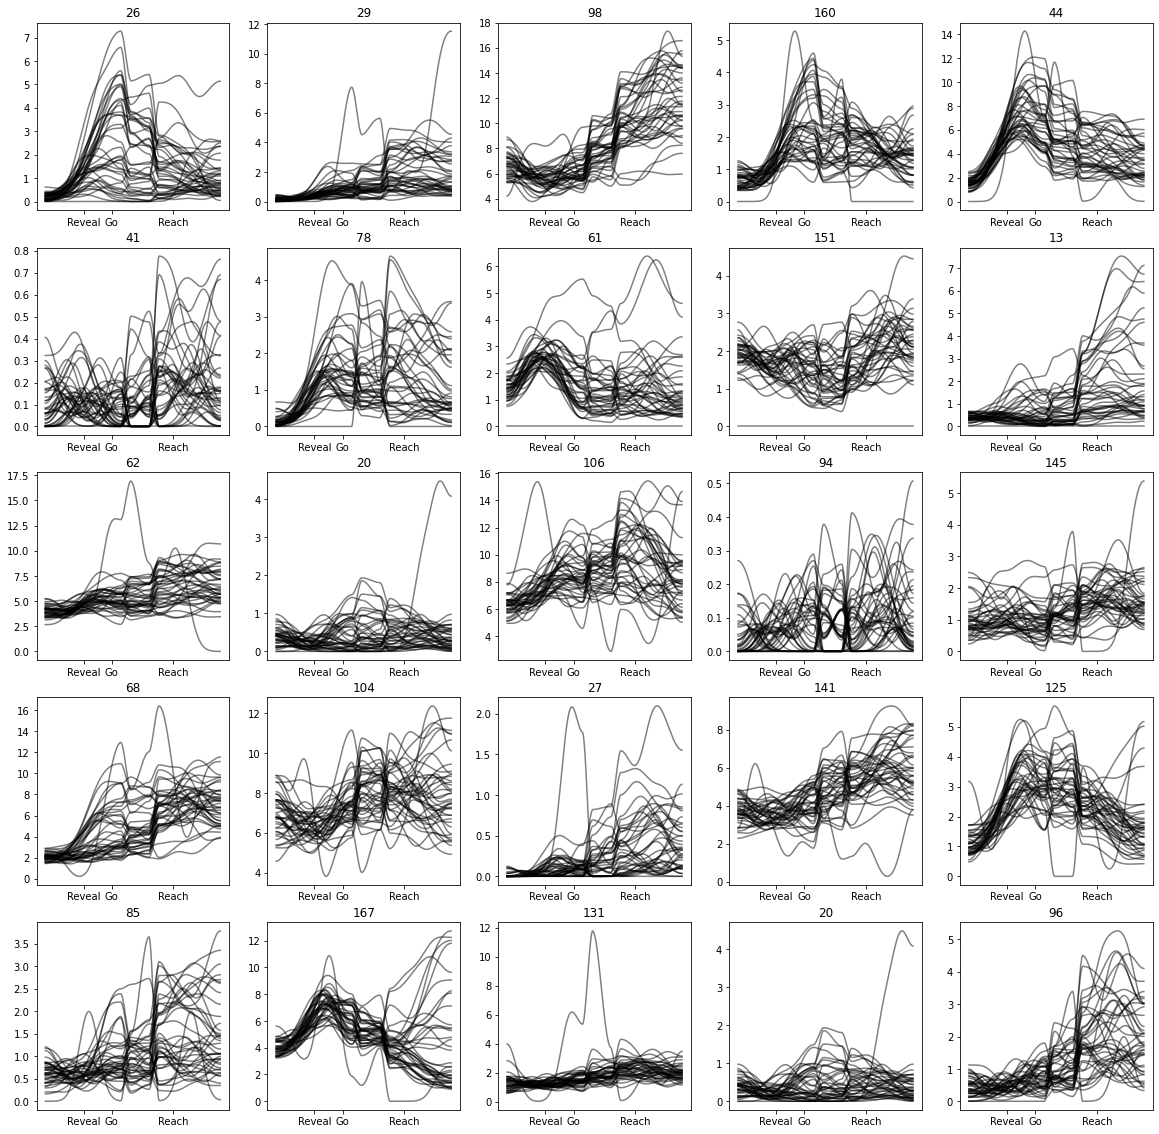

In [291]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))


idxs = [26, 29, 98, 160]
idxs.extend(list(np.random.choice(fr_.shape[-1], 21, replace='False')))

for i in range(25):
    a = ax[np.unravel_index(i, (5, 5))]
    a.plot(fr_[..., idxs[i]].T, color='k', alpha=0.5)
    a.set_title(idxs[i])
    a.set_xticks([80, 139, 268])
    a.set_xticklabels(['Reveal', 'Go', 'Reach'])

fig.savefig('shenoy_debugging/condition_traces.pdf', bbox_inches='tight', pad_inches=0)

In [292]:
jpcamodel = JPCA(n_components=6, mean_subtract=True)
jpcamodel.fit(fr_m)
y = jpcamodel.transform(fr_m)

In [299]:
varmodel = VAR(estimator='ols')
varmodel.fit(fr_m)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [300]:
varmodel2 = VAR(estimator='ols', order=2)
varmodel2.fit(fr_m)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [8]:
import matplotlib as mpl

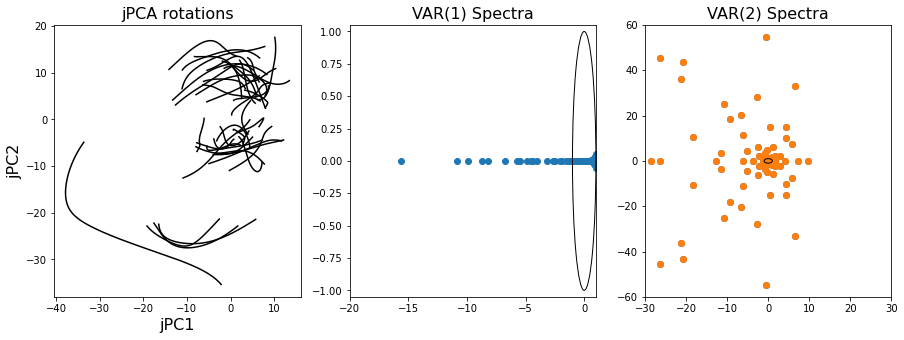

In [314]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(0, y.shape[0]):
    ax[0].plot(y[i, :, 0], y[i, :, 1], color='k')
    ax[0].arrow(y[i, -1, 0], y[i, -1, 1], y[i, -1, 0] - y[i, -2, 0], y[i, -1, 1] - y[i, -2, 1], 
                   head_width=0.025, color="#518570")

evals = np.linalg.eigvals(np.squeeze(varmodel.coef_))
circle = mpl.patches.Circle((0, 0), 1, color='k', fill=False)
ax[1].set_xlim([-20, 1])
ax[1].set_ylim([-1.05, 1.05])
ax[1].scatter(np.real(evals), np.imag(evals))
ax[1].add_patch(circle)

evals = np.linalg.eigvals(form_companion(varmodel2.coef_))
circle = mpl.patches.Circle((0, 0), 1, color='k', fill=False)
ax[2].scatter(np.real(evals), np.imag(evals))
ax[2].set_xlim([-30, 30])
ax[2].set_ylim([-60, 60])
ax[2].scatter(np.real(evals), np.imag(evals))
ax[2].add_patch(circle)


ax[0].set_title('jPCA rotations', fontsize=16)
ax[0].set_xlabel('jPC1', fontsize=16)
ax[0].set_ylabel('jPC2', fontsize=16)

ax[1].set_title('VAR(1) Spectra', fontsize=16)
ax[2].set_title('VAR(2) Spectra', fontsize=16)
fig.savefig('shenoy_debugging/jpc_ols.pdf', bbox_inches='tight', pad_inches=0)

In [32]:
x -= np.mean(x, axis=0)

In [33]:
varmodel = VAR(estimator = 'ols')
varmodel.fit(x)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [34]:
eigvals = np.linalg.eigvals(np.squeeze(varmodel.coef_))

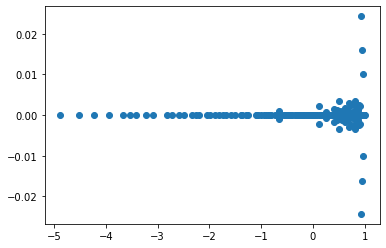

In [35]:
plt.scatter(np.real(eigvals), np.imag(eigvals))

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Stanard

In [81]:
# Reproduce JPCA results
# Normalize across conditions
x -= np.mean(x, axis=0)

# Apply PCA across time and conditions
pcamodel = PCA()
pcamodel.fit(np.reshape(x, (-1, 202)))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

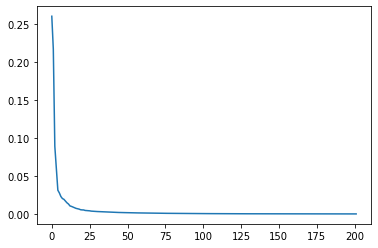

In [82]:
# variance per dimension
plt.plot(pcamodel.explained_variance_ratio_)

In [83]:
# Project x onto the leading 6 PCA components and then fit jPCA

In [94]:
from dca.methods_comparison import JPCA

In [96]:
jpcamodel = JPCA(n_components=6, mean_subtract=True)
jpcamodel.fit(x)

In [97]:
y = jpcamodel.transform(x)

In [98]:
y.shape

(40, 299, 6)

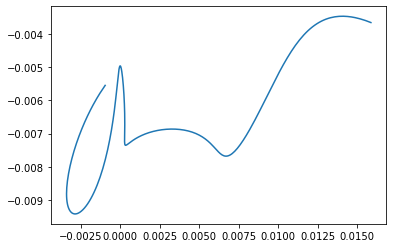

In [106]:
plt.plot(y[6, :, 0].ravel(), y[6, :, 1].ravel())

### Using the example data provided by Churchland

In [10]:
from scipy.io import loadmat

dat = loadmat("/media/akumar/Secondary/data/exampleData.mat")
firing_rates = [dat['Data'][0][idx][0][np.newaxis, :] for idx in range(108)]
t = [dat['Data'][0][idx][1][np.newaxis, :] for idx in range(108)]
x = np.concatenate(firing_rates)
t = np.concatenate(t)
# Restrict to 300 ms after movement onset
X = x[:, list(np.where(t[0] < 150)[0]), :]

In [11]:
# JPCA
jpcamodel = JPCA(n_components=6, mean_subtract=True)
jpcamodel.fit(X)
y = jpcamodel.transform(X)

In [12]:
# JPCA with normalization
jpcamodel2 = JPCA(n_components=6, mean_subtract=False)
# Cross condition mean subtracted manually
x = X - np.mean(X, axis=0)
x = standardize(x)
jpcamodel2.fit(x)
y2 = jpcamodel2.transform(x)

In [318]:
# VAR(1) without normalization
x = X - np.mean(X, axis=0)
yy = np.array([y_ @ jpcamodel.pca_.components_.T for y_ in x])
# Subtract cross condition mean
#yy -= np.mean(yy, axis=0)
#yy = standardize(yy)
varmodel = VAR(estimator='ols')
varmodel.fit(yy)
eigvals, eigvecs = np.linalg.eig(np.squeeze(varmodel.coef_))
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 = v2/np.linalg.norm(v2)
V1 = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
yy2 = np.stack([y_ @ V1 for y_ in yy], axis=0)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5


In [319]:
# VAR(1) with standardization
x = X - np.mean(X, axis=0)
yy = np.array([y_ @ jpcamodel.pca_.components_.T for y_ in x])
# Subtract cross condition mean
#yy -= np.mean(yy, axis=0)
yy = standardize(yy)
varmodel2 = VAR(estimator='ols')
varmodel2.fit(yy)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5


In [320]:
# VAR(1) on numerical differences
x = X - np.mean(X, axis=0)
yy = np.array([y_ @ jpcamodel.pca_.components_.T for y_ in x])
# Subtract cross condition mean
yy -= np.mean(yy, axis=0)
#yy = standardize(yy)
yydot = np.diff(yy, axis=1)
linmodel = LinearRegression(normalize=True, fit_intercept=True)
linmodel.fit(yy[:, :-1, :].reshape((-1, 6)), yydot.reshape((-1, 6)))
eigvals, eigvecs = np.linalg.eig(np.squeeze(linmodel.coef_))
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 /= np.linalg.norm(v2)
V2 = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
yy3 = np.stack([y_ @ V2 for y_ in yy], axis=0)

In [321]:
# VAR(1) on numerical differences with standardization
x = X - np.mean(X, axis=0)
yy = np.array([y_ @ jpcamodel.pca_.components_.T for y_ in x])
# Subtract cross condition mean
yy -= np.mean(yy, axis=0)
yy = standardize(yy)
yydot = np.diff(yy, axis=1)
linmodel2 = LinearRegression(normalize=True, fit_intercept=True)
linmodel2.fit(yy[:, :-1, :].reshape((-1, 6)), yydot.reshape((-1, 6)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [10]:
import matplotlib as mpl

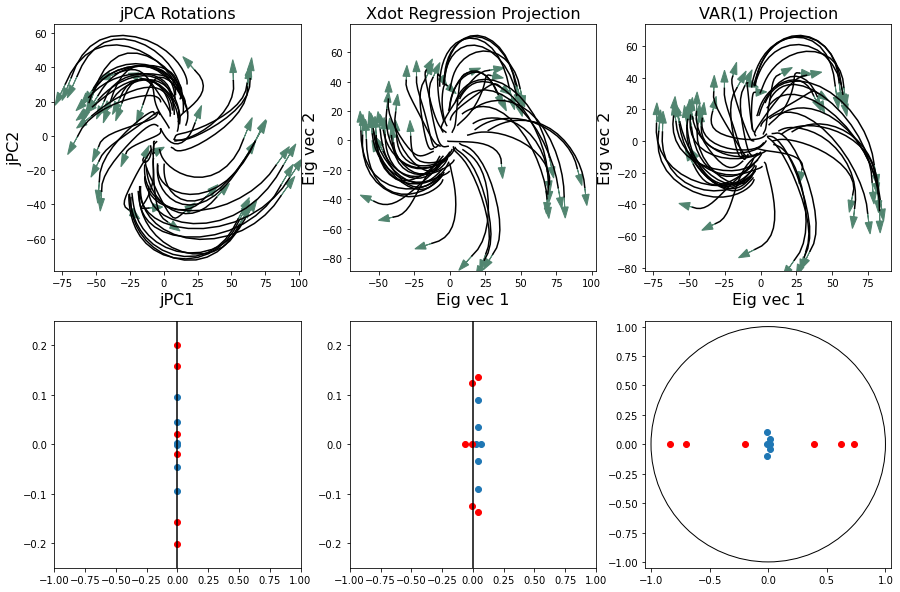

In [325]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(0, y.shape[0], 2):
    ax[0, 0].plot(y[i, :, 0], y[i, :, 1], color='k')
    ax[0, 0].arrow(y[i, -1, 0], y[i, -1, 1], y[i, -1, 0] - y[i, -2, 0], y[i, -1, 1] - y[i, -2, 1], 
                   head_width=5, color="#518570")

ax[1, 0].scatter(np.zeros(6), jpcamodel.eigen_vals_)
ax[1, 0].scatter(np.zeros(6), jpcamodel2.eigen_vals_, color='r')

ax[1, 0].set_xlim([-1, 1])
ax[1, 0].set_ylim([-0.25, 0.25])
ax[1, 0].vlines(0, -0.25, 0.25, color='k')

for i in range(0, y.shape[0], 2):
    ax[0, 1].plot(yy3[i, :, 0], yy3[i, :, 1], color='k')
    ax[0, 1].arrow(yy3[i, -1, 0], yy3[i, -1, 1], yy3[i, -1, 0] - yy3[i, -2, 0], yy3[i, -1, 1] - yy3[i, -2, 1], 
                   head_width=5, color="#518570")    

    
eigvals, eigvecs = np.linalg.eig(np.squeeze(linmodel.coef_))
ax[1, 1].scatter(np.real(eigvals), np.imag(eigvals))
eigvals, eigvecs = np.linalg.eig(np.squeeze(linmodel2.coef_))
ax[1, 1].scatter(np.real(eigvals), np.imag(eigvals), color='r')
ax[1, 1].set_xlim([-1, 1])
ax[1, 1].set_ylim([-0.25, 0.25])
ax[1, 1].vlines(0, -0.25, 0.25, color='k')


for i in range(0, y.shape[0], 2):
    ax[0, 2].plot(yy2[i, :, 0], yy2[i, :, 1], color='k')
    ax[0, 2].arrow(yy2[i, -1, 0], yy2[i, -1, 1], yy2[i, -1, 0] - yy2[i, -2, 0], yy2[i, -1, 1] - yy2[i, -2, 1], 
                   head_width=5, color="#518570")

eigvals, eigvecs = np.linalg.eig(np.squeeze(varmodel.coef_))
ax[1, 2].scatter(np.real(eigvals), np.imag(eigvals))
eigvals, eigvecs = np.linalg.eig(np.squeeze(varmodel2.coef_))
ax[1, 2].scatter(np.real(eigvals), np.imag(eigvals), color='r')

ax[1, 2].set_xlim([-1.05, 1.05])
ax[1, 2].set_ylim([-1.05, 1.05])
circle = mpl.patches.Circle((0, 0), 1, color='k', fill=False)
ax[1, 2].add_patch(circle)

ax[0, 0].set_title('jPCA Rotations', fontsize=16)
ax[0, 1].set_title('Xdot Regression Projection', fontsize=16)
ax[0, 2].set_title('VAR(1) Projection', fontsize=16)

ax[0, 0].set_xlabel('jPC1', fontsize=16)
ax[0, 0].set_ylabel('jPC2', fontsize=16)

ax[0, 1].set_xlabel('Eig vec 1', fontsize=16)
ax[0, 1].set_ylabel('Eig vec 2', fontsize=16)

ax[0, 2].set_xlabel('Eig vec 1', fontsize=16)
ax[0, 2].set_ylabel('Eig vec 2', fontsize=16)

fig.savefig('shenoy_debugging/example_data_plot1.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Do OLS/diff OLS on ambient space

In [14]:
x = np.concatenate(firing_rates)
x -= np.mean(x, axis=0)

In [15]:
xxdot = np.diff(x, axis=1)
linmodel = LinearRegression(normalize=False, fit_intercept=False)
linmodel.fit(x[:, :-1, :].reshape((-1, 218)), xxdot.reshape((-1, 218)))
# A manual check shows the largest imaginary eigvals comes first
eigvals, eigvecs = np.linalg.eig(np.squeeze(linmodel.coef_))
eigorder = np.argsort(np.abs(np.imag(eigvals)))[::-1]
eigvecs = eigvecs[:, eigorder]
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 /= np.linalg.norm(v2)
V = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
xx = np.stack([x_ @ V for x_ in x], axis=0)

In [42]:
varmodel = VAR(estimator='ols')
varmodel.fit(x)
eigvals, eigvecs = np.linalg.eig(np.squeeze(varmodel.coef_))
eigorder = np.argsort(np.abs(np.imag(eigvals)))[::-1]
eigvecs = eigvecs[:, eigorder]
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 /= np.linalg.norm(v2)
V2 = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
xx2 = np.stack([x_ @ V2 for x_ in x], axis=0)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [14]:
varmodel2 = VAR(estimator='ncv', penalty='scad')
varmodel2.fit(x)
eigvals, eigvecs = np.linalg.eig(np.squeeze(varmodel2.coef_))
eigorder = np.argsort(np.abs(np.imag(eigvals)))[::-1]
eigvecs = eigvecs[:, eigorder]
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 /= np.linalg.norm(v2)
V3 = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
xx3 = np.stack([x_ @ V3 for x_ in x], axis=0)

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

In [ ]:
# This will crash the kernel
jpcamodel = JPCA(n_components =x.shape[-1] ,mean_subtract=False)
jpcamodel.fit(x)
xx4 = jpcamodel.transform(x)

In [ ]:
# Fit VAR(3) - Do we get more non-normality?

In [34]:
from neurosim.models.var import form_companion
from dca.cov_util import form_lag_matrix

In [27]:
x[0].shape

(61, 218)

In [36]:
form_lag_matrix(x[0], 2).shape

(60, 436)

In [21]:
varmodel3 = VAR(estimator='ols', order=2)
varmodel3.fit(x)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [ ]:
# interesting enough...

In [22]:
A = form_companion(varmodel3.coef_)

In [37]:
eigvals, eigvecs = np.linalg.eig(A)
eigorder = np.argsort(np.abs(np.imag(eigvals)))[::-1]
eigvecs = eigvecs[:, eigorder]
v1 = np.real(eigvecs[0, :] + eigvecs[1, :])
v1 /= np.linalg.norm(v1)
v2 = np.imag(eigvecs[0, :] - eigvecs[1, :])
v2 /= np.linalg.norm(v2)
V4 = np.concatenate([v1[:, np.newaxis], v2[:, np.newaxis]], axis=1)
xx4 = np.stack([form_lag_matrix(x_, 2) @ V4 for x_ in x], axis=0)

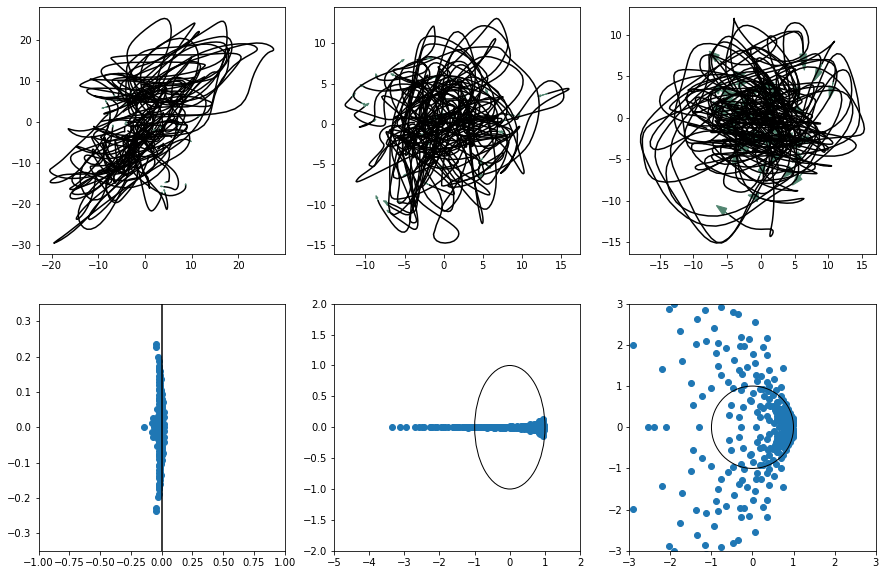

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(0, y.shape[0], 2):
    ax[0, 0].plot(xx[i, :, 0], xx[i, :, 1], color='k')
    ax[0, 0].arrow(xx[i, -1, 0], xx[i, -1, 1], xx[i, -1, 0] - xx[i, -2, 0], xx[i, -1, 1] - xx[i, -2, 1], 
                   head_width=0.25, color="#518570")

ax[1, 0].scatter(np.real(np.linalg.eigvals(linmodel.coef_)), np.imag(np.linalg.eigvals(linmodel.coef_)))
ax[1, 0].set_xlim([-1, 1])
ax[1, 0].set_ylim([-0.35, 0.35])
ax[1, 0].vlines(0, -0.35, 0.35, color='k')

for i in range(0, y.shape[0], 2):
    ax[0, 1].plot(xx2[i, :, 0], xx2[i, :, 1], color='k')
    ax[0, 1].arrow(xx2[i, -1, 0], xx2[i, -1, 1], xx2[i, -1, 0] - xx2[i, -2, 0], xx2[i, -1, 1] - xx2[i, -2, 1], 
                   head_width=0.25, color="#518570")

evals = np.linalg.eigvals(np.squeeze(varmodel.coef_))
ax[1, 1].scatter(np.real(evals), np.imag(evals))
ax[1, 1].set_xlim([-5, 2])
ax[1, 1].set_ylim([-2, 2])
circle = mpl.patches.Circle((0, 0), 1, color='k', fill=False)
ax[1, 1].add_patch(circle)

evals = np.linalg.eigvals(A)
for i in range(0, y.shape[0], 2):
    ax[0, 2].plot(xx4[i, :, 0], xx4[i, :, 1], color='k')
    ax[0, 2].arrow(xx4[i, -1, 0], xx4[i, -1, 1], xx4[i, -1, 0] - xx4[i, -2, 0], xx4[i, -1, 1] - xx4[i, -2, 1], 
                   head_width=1, color="#518570")
    
ax[1, 2].scatter(np.real(evals), np.imag(evals))
ax[1, 2].set_xlim([-3, 3])
ax[1, 2].set_ylim([-3, 3])
circle = mpl.patches.Circle((0, 0), 1, color='k', fill=False)
ax[1, 2].add_patch(circle)

fig.savefig('shenoy_debugging/example_plot2.pdf', bbox_inches='tight', pad_inches=0)

### Affinewarp

In [57]:
import affinewarp 
from affinewarp import ShiftWarping, PiecewiseWarping

In [107]:
LINEAR_SMOOTHNESS_REG = 0.5
LINEAR_WARP_REG = 1e-2

# Hyperparameters for shift-only warping model.
SHIFT_SMOOTHNESS_REG = 0.5
SHIFT_WARP_REG = 1e-2
MAXLAG = 0.5

In [ ]:
# First try time warping prior to smoothing - try various bin widths

In [85]:
loader_kwargs = {'bin_width':4, 'filter_fn':'none', 'filter_kwargs':{}, 
               'boxcox':None, 'spike_threshold':1, 'trial_threshold':0.0, 'tw':(-100, 200)}

In [86]:
x = split_and_norm_shenoy('/media/akumar/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat', 
                            '/media/akumar/Secondary/data/shenoy_normsplit', 
                             **loader_kwargs)

268 Bad Trials being thrown away


In [87]:
x[1].shape

(55, 86, 202)

In [119]:
# Specify model.
shift_model = ShiftWarping(
    smoothness_reg_scale=SHIFT_SMOOTHNESS_REG,
    warp_reg_scale=SHIFT_WARP_REG,
    maxlag=MAXLAG,
    loss='poisson'
)

xwarp = []

# Fit to binned spike times.
for idx in range(len(x)):
    shift_model.fit(x[idx], iterations=50)
    xwarp.append(shift_model.transform(x[idx]))

Loss: 0.07: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


In [120]:
# Specify model.
lin_model = PiecewiseWarping(
    n_knots=1,
    smoothness_reg_scale=LINEAR_SMOOTHNESS_REG,
    warp_reg_scale=LINEAR_WARP_REG,
    loss='poisson',
    n_restarts=5
)

xpiecewarp = []

# Fit to binned spike times.
for idx in range(len(x)):
    lin_model.fit(x[idx], iterations=50)
    xpiecewarp.append(lin_model.transform(x[idx]))

Loss improvement: 10.08%: 100%|██████████| 50/50 [03:01<00:00,  3.64s/it]


Text(0, 0.5, 'Normalized Loss')

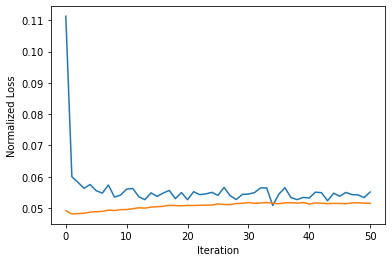

In [109]:
plt.plot(shift_model.loss_hist, label="shift")
plt.plot(lin_model.loss_hist, label="linear")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")

In [ ]:
# What is the visualization? Plot single neuron firing rates post smoothing averaged across trials

In [117]:
x[1].shape

(55, 86, 202)

In [123]:
x0 = [gaussian_filter1d(x[idx].astype(np.float), axis=1, sigma=5) for idx in range(len(x))]

In [124]:
x1 = [gaussian_filter1d(xwarp[idx].astype(np.float), axis=1, sigma=5) for idx in range(len(xwarp))]

In [125]:
x2 = [gaussian_filter1d(xpiecewarp[idx].astype(np.float), axis=1, sigma=5) for idx in range(len(xwarp))]

In [132]:
x0avg = np.array([np.mean(x_, axis=0, keepdims=False) for x_ in x0])
x1avg = np.array([np.mean(x_, axis=0, keepdims=False) for x_ in x1])
x2avg = np.array([np.mean(x_, axis=0, keepdims=False) for x_ in x2])

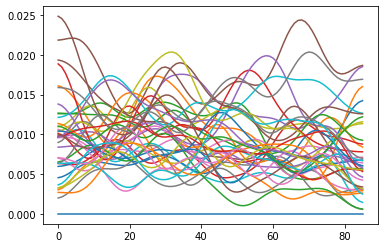

In [171]:
plt.plot(x2avg[..., 200].T)

In [153]:
import pickle

In [154]:
with open('tw_shenoy.dat', 'wb') as f:
    f.write(pickle.dumps(xwarp))
    f.write(pickle.dumps(xpiecewarp))

In [150]:
jpcamodel = JPCA(n_components=6, mean_subtract=True)
jpcamodel.fit(x0avg)
y0 = jpcamodel.transform(x0avg)

In [151]:
jpcamodel2 = JPCA(n_components=6, mean_subtract=True)
jpcamodel2.fit(x1avg)
y1 = jpcamodel2.transform(x1avg)

In [152]:
jpcamodel3 = JPCA(n_components=6, mean_subtract=True)
jpcamodel3.fit(x2avg)
y2 = jpcamodel3.transform(x2avg)

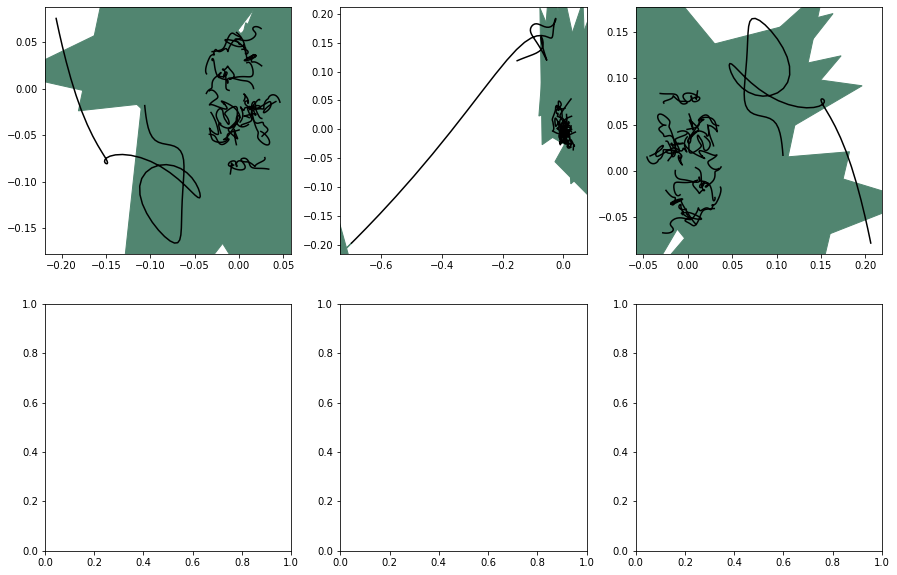

In [156]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(0, y.shape[0], 2):
    ax[0, 0].plot(y0[i, :, 0], y0[i, :, 1], color='k')
    ax[0, 0].arrow(y0[i, -1, 0], y0[i, -1, 1], y0[i, -1, 0] - y0[i, -2, 0], y0[i, -1, 1] - y0[i, -2, 1], 
                   head_width=.15, color="#518570")

for i in range(0, y.shape[0], 2):
    ax[0, 1].plot(y1[i, :, 0], y1[i, :, 1], color='k')
    ax[0, 1].arrow(y1[i, -1, 0], y1[i, -1, 1], y1[i, -1, 0] - y1[i, -2, 0], y1[i, -1, 1] - y1[i, -2, 1], 
                   head_width=.15, color="#518570")    

for i in range(0, y.shape[0], 2):
    ax[0, 2].plot(y2[i, :, 0], y2[i, :, 1], color='k')
    ax[0, 2].arrow(y2[i, -1, 0], y2[i, -1, 1], y2[i, -1, 0] - y2[i, -2, 0], y2[i, -1, 1] - y2[i, -2, 1], 
                   head_width=.15, color="#518570")


### Bin width selection 

In [139]:
def optimal_bin_width(spike_times, T, bin_widths):
    
    # From https://direct.mit.edu/neco/article/19/6/1503/7188/A-Method-for-Selecting-the-Bin-Size-of-a-Time
    
    cost = np.zeros(len(bin_widths))
    ntrials = len(spike_times)
    # spike_times must be a list of length n_trials
    for i, bin_width in enumerate(bin_widths):
        bins = np.linspace(0, T, T//bin_width)
        spike_counts = np.zeros((len(spike_times), bins.size))
        for trial in range(ntrials):
            spike_counts[trial, :] = np.histogram(spike_times, bins=bins)
        spike_counts = np.sum(spike_counts, axis=0)
        mean_counts = np.mean(spike_counts)
        var_counts = np.var(spike_counts)
        
        cost[i] = (2 * mean_counts - var_counts)/(ntrials * bin_width)**2
        
    return bin_widths[np.argmin(cost)]

In [140]:
gauss_kernel = lambda s, bw: 1/np.sqrt(2 * np.pi * bw**2) * np.exp(-s**2/(2 * bw**2))

In [141]:
# dt: discretization timescale
# From J Comput Neurosci (2010) 29:171–182 173
def optimal_smoothing_bandwith(spike_times, T, dt, bandwidths, kernel_fn):
        
    phi_integrand = lambda t, t1, t2, bw: gauss_kernel(t - t1, bw) * gauss_kernel(t - t2, bw)
    
    phi = lambda t1, t2, bw: integrate.quad(phi_integrand, 0, T, args=(t1, t2, bw))[0]
    
    cost = np.zeros(len(bandwidths))
    ntrials = len(spike_times)
    for i, bw in enumerate(bandwidths):
        spike_times_ = []
        for trial in range(ntrials):
            spike_times_.extend(spike_times[trial])

        # To save computational time, ignore spike times farther than 4 times the bandwidth from 
        # each other            
        for j, t1 in enumerate(spike_times_):
            for k, t2 in enumerate(spike_times_):
                if np.abs(t1 - t2) > 4 * bw:
                    continue
                else:
                    cost[i] += 1/ntrials**2 * phi(t1, t2, bw)
                    
                    if j != k:
                        cost[j] -= 2/ntrials**2 * kernel_fn(t1 - t2, bw)
                        
    return bandwidths[np.argmin(cost)]

In [200]:
def postprocess_spikes(spike_times, T, bin_width, 
                       boxcox, filter_fn, filter_kwargs):
    # Discretize time over bins
    bins = np.linspace(0, T, int(T//bin_width))
    spike_rates = np.zeros((spike_times.shape[0], spike_times.shape[1], bins.size - 1))
    for i in range(spike_rates.shape[0]):
        for j in range(spike_rates.shape[1]):    
            spike_counts = np.histogram(spike_times[i, j], bins=bins)[0]

            # Apply a boxcox transformation
            if boxcox is not None:
                spike_counts = np.array([(np.power(spike_count, boxcox) - 1)/boxcox 
                                         for spike_count in spike_counts])

            # Filter the resulting spike counts
            spike_rates[i, j, :] = filter_fn(spike_counts, filter_kwargs)
    return spike_rates

In [165]:
def align_behavior(x, bin_width):
    
    bins = np.linspace(0, x.size, x.size//bin_width)
    bin_centers = bins + (bins[1] - bins[0])/2
    interpolator = interp1d(np.linspace(0, x.size), x)
    return interpolator(bin_centers)    

In [47]:
# Gelfand inequality
A = np.random.normal(size=(10, 10))

In [49]:
max(np.abs(np.linalg.eigvals(A)))

2.6580595526078565

In [66]:
a1 = [np.linalg.norm(np.linalg.matrix_power(A, k), ord='nuc')**(1/k) for k in range(1, 100)]
a2 = [np.linalg.norm(np.linalg.matrix_power(A, k), ord='fro')**(1/k) for k in range(1, 100)]
a3 = [np.linalg.norm(np.linalg.matrix_power(A, k), ord=2)**(1/k) for k in range(1, 100)]

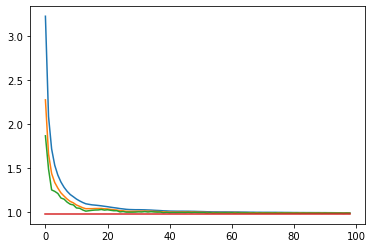

In [68]:
plt.plot(np.log(a1))
plt.plot(np.log(a2))
plt.plot(np.log(a3))
plt.plot(np.log(2.658) * np.ones(len(a1)))